In [1]:
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import synthetic_data_generator.seismogram_generator as seismogram_generator

/home/alexsey/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('config_fix.json', 'r') as f:
    config = json.load(f)

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Network fixer

In [4]:
class Helper(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.first_encoder_block = torch.nn.Sequential(
            torch.nn.Conv2d(2,64,(3, 3), padding = (1,1)),
            torch.nn.BatchNorm2d(64),
            torch.nn.GELU(),
            torch.nn.Conv2d(64,2,(3, 3), padding = (1,1)),
            torch.nn.Softmax(dim=1))
            
    def forward(self, x):
        e1 = self.first_encoder_block(x)
    
        return e1

In [5]:
helper_model = Helper()
loss_function = torch.nn.BCEWithLogitsLoss()

In [6]:
helper_model.to(device)

Helper(
  (first_encoder_block): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Softmax(dim=1)
  )
)

## Load network which to fix

In [7]:
model = smp.MAnet(
    encoder_name="resnet34",       
    encoder_weights=None,     
    in_channels=1,                  
    classes=2,
    activation='softmax',
    decoder_pab_channels = 64
)

In [8]:
model.load_state_dict(torch.load(config['model_path']))

<All keys matched successfully>

In [9]:
model.to(device)

MAnet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## Dataset and dataloader

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, model, configs):
        'Initialization'
        self.model = model
        self.epoch_len = configs['epoch_len']

    def __len__(self):
        return self.epoch_len

    def __getitem__(self, index):
        'Generates one sample of data'
        X,mask = seismogram_generator.get_sample()
        pred_mask = self.model(X[None,None,:,:])[0]
        
        return pred_mask, mask

In [11]:
params = {'batch_size': config['batch_size'],
          'shuffle': config['shuffle']}

In [12]:
training_set = Dataset(model, config)
training_generator = torch.utils.data.DataLoader(training_set, **params)

## Training loop

In [13]:
def dice_loss(pred, target, smooth=1.):
    """Dice loss
    """
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

/home/alexsey/miniconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


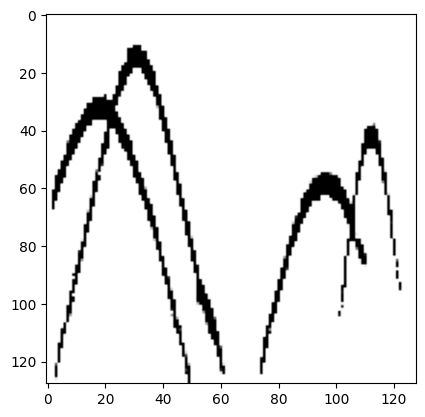

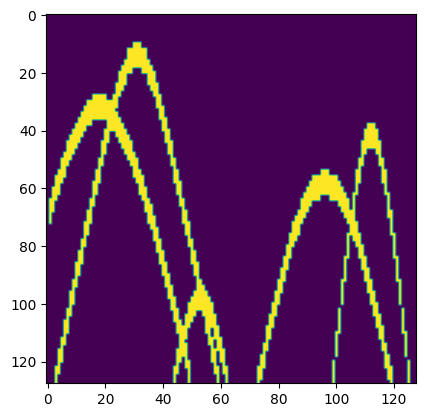

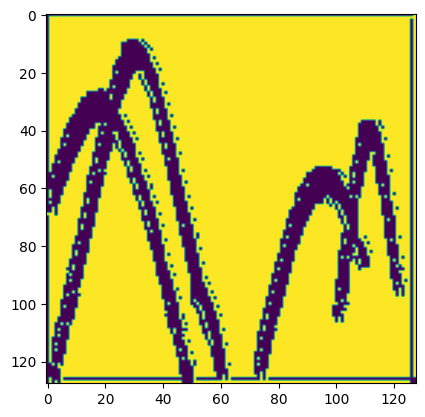

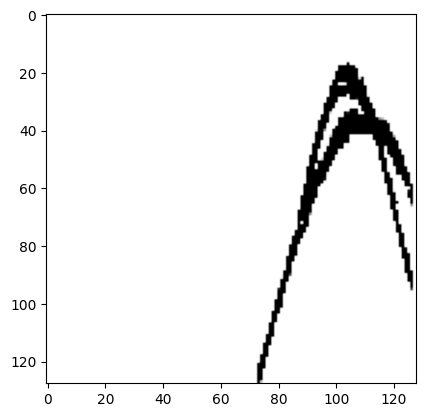

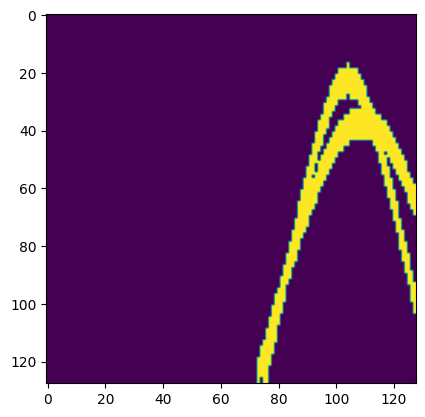

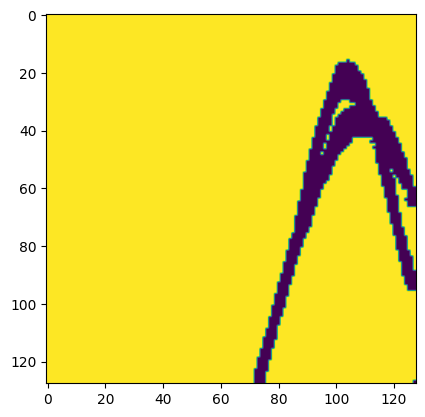

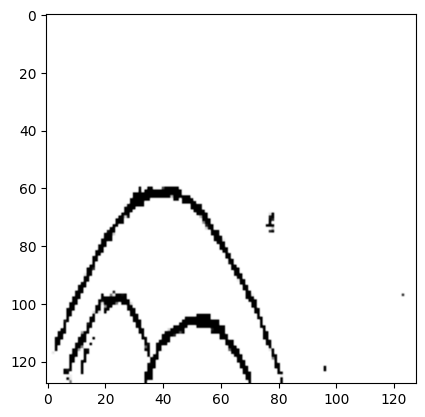

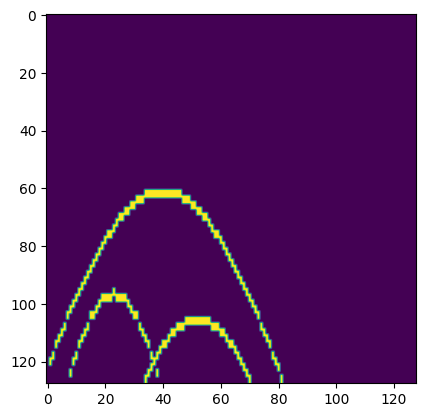

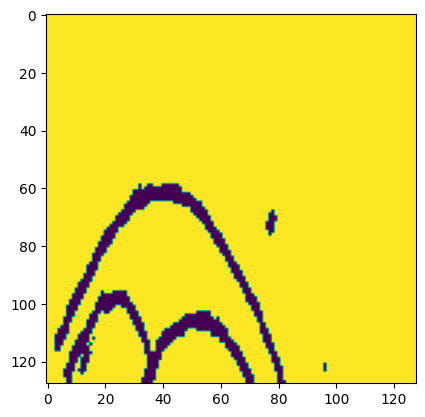

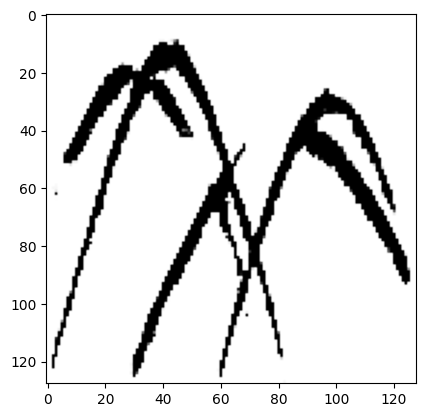

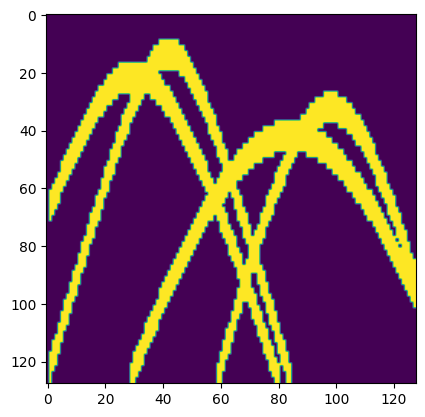

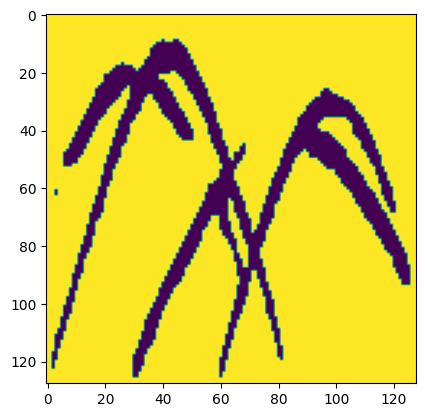

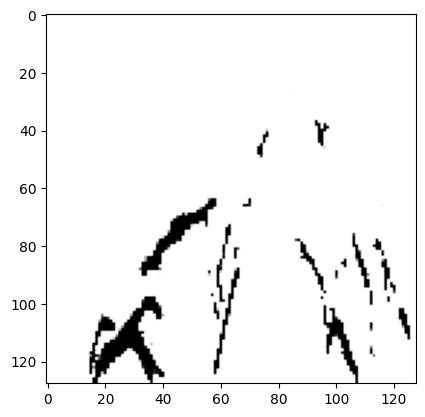

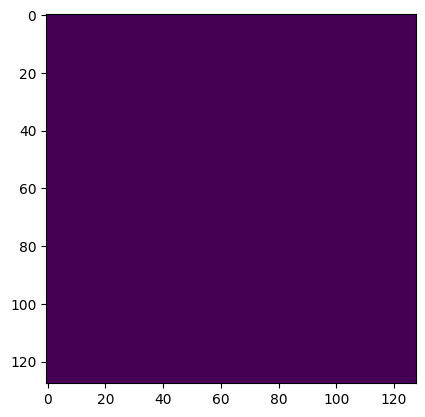

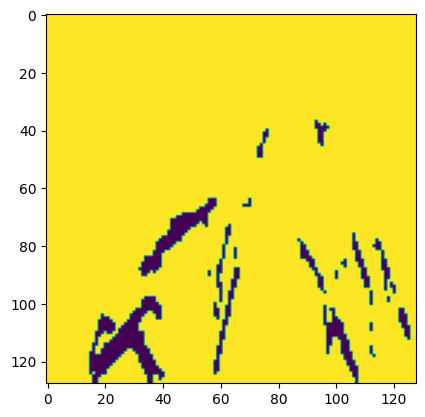

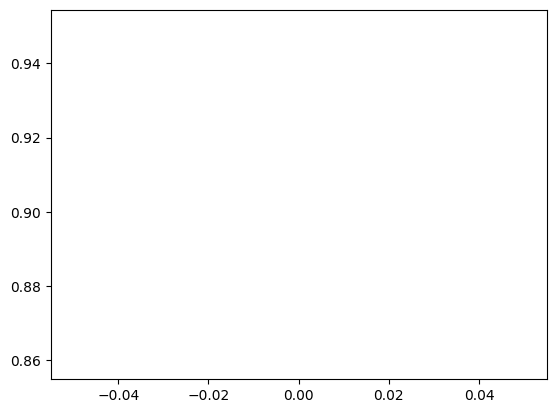

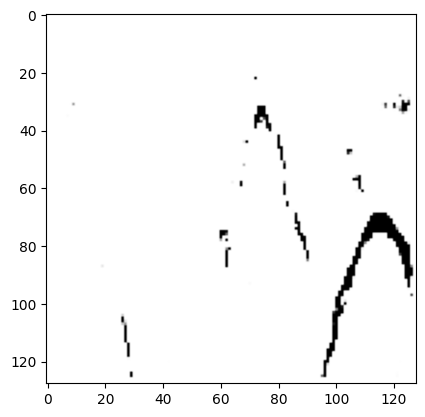

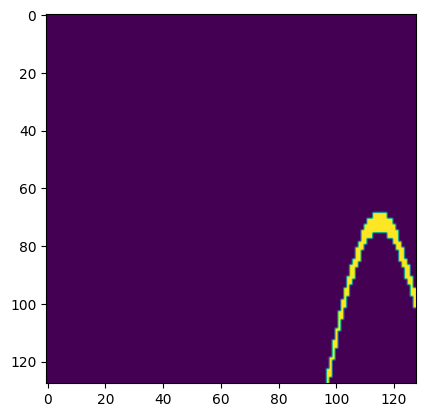

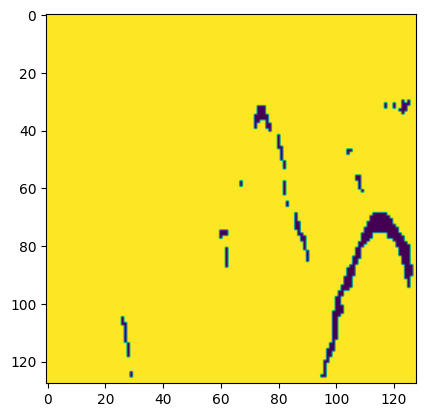

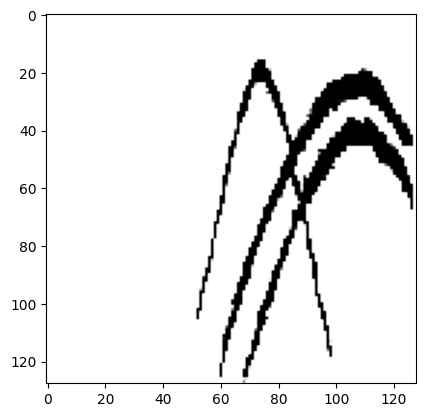

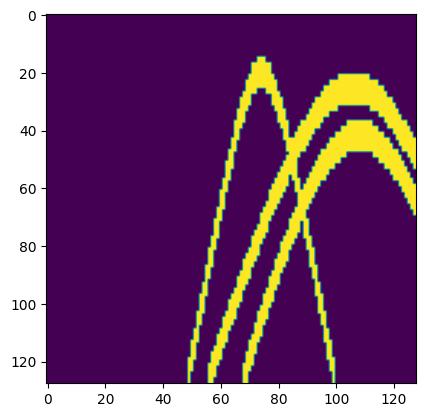

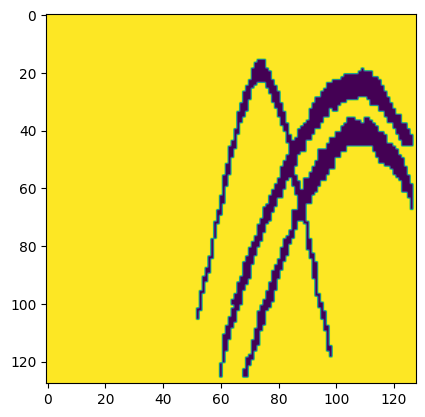

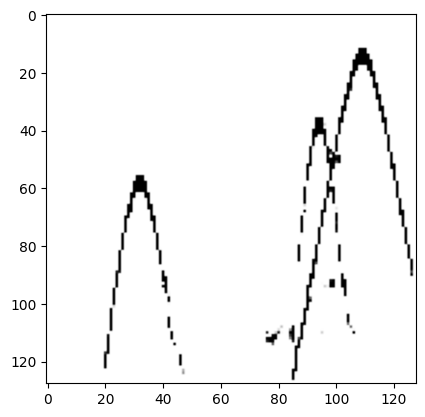

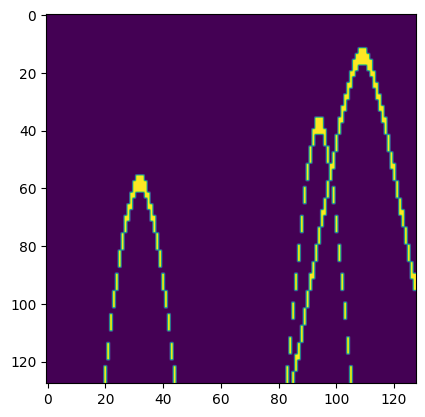

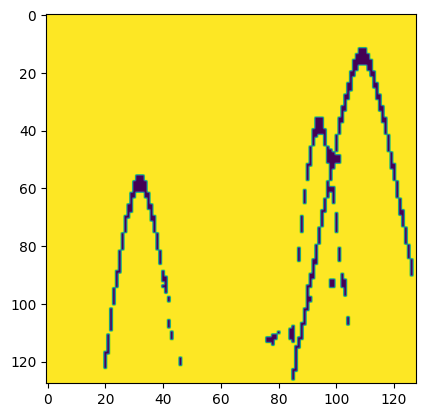

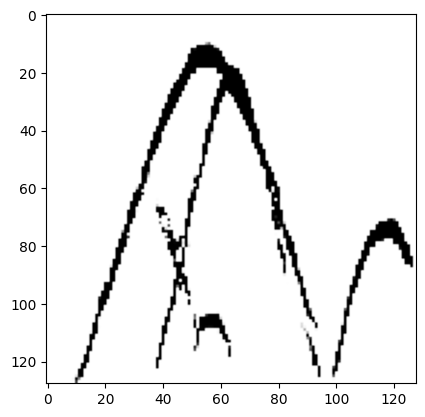

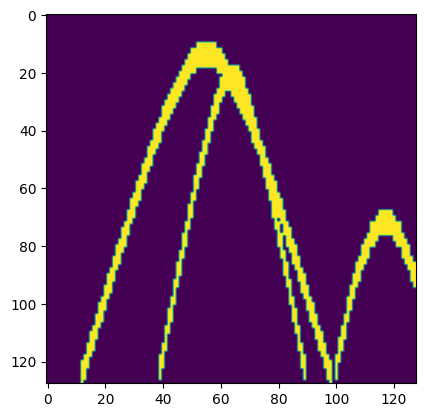

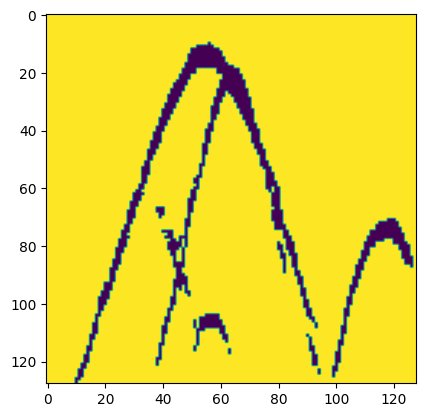

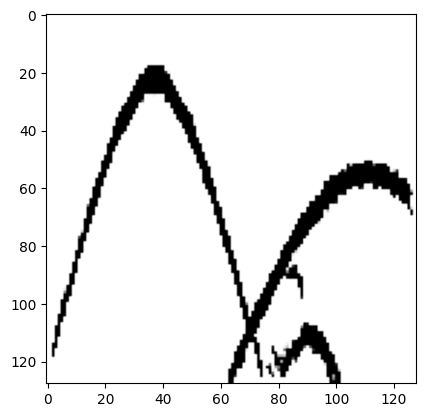

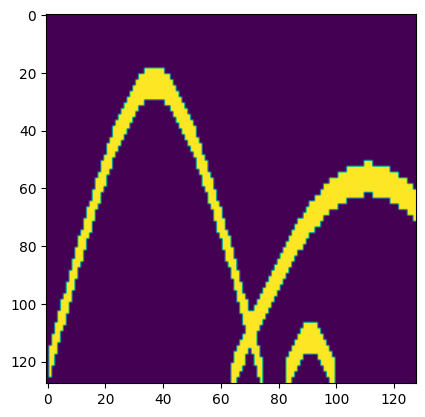

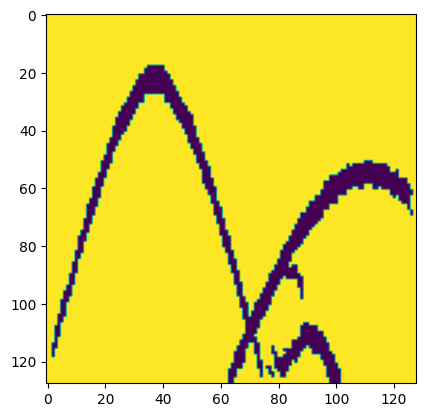

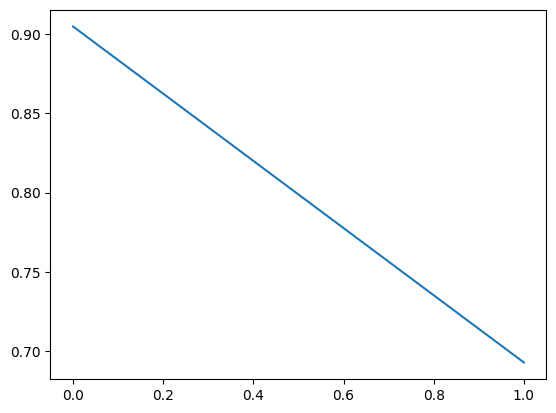

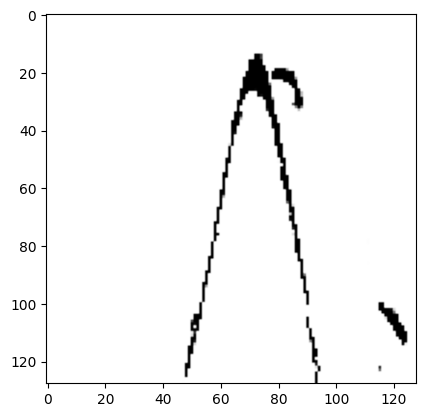

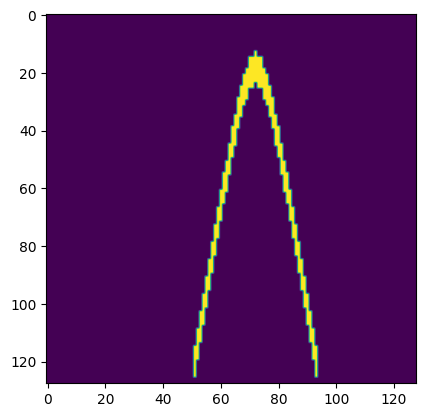

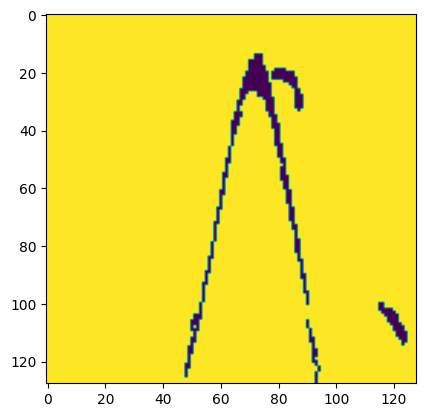

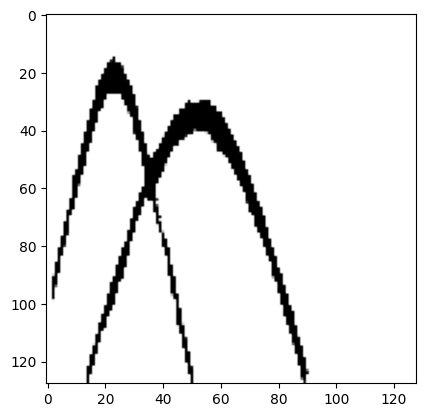

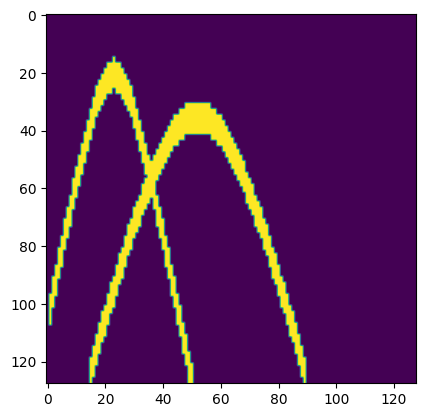

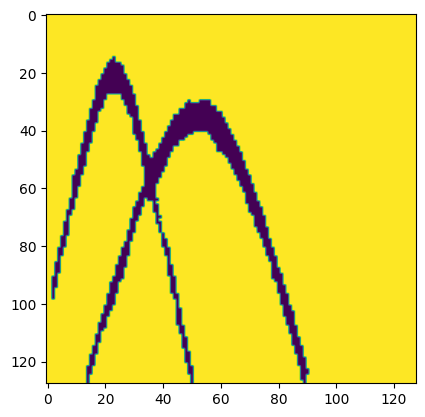

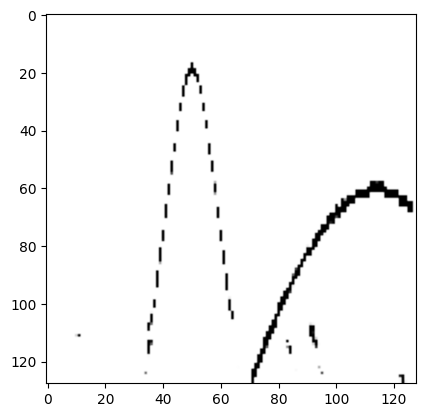

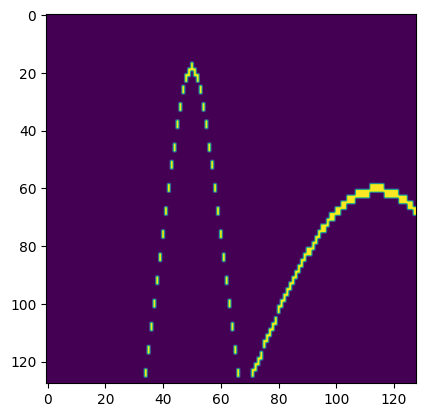

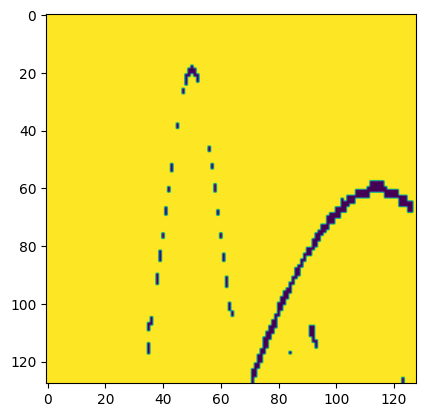

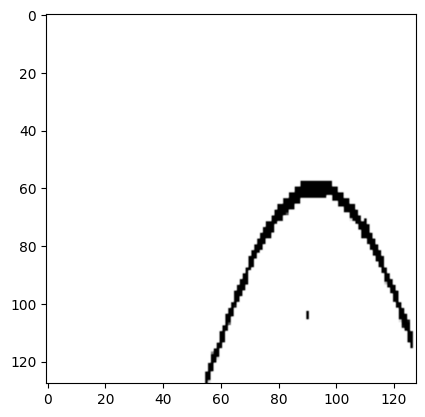

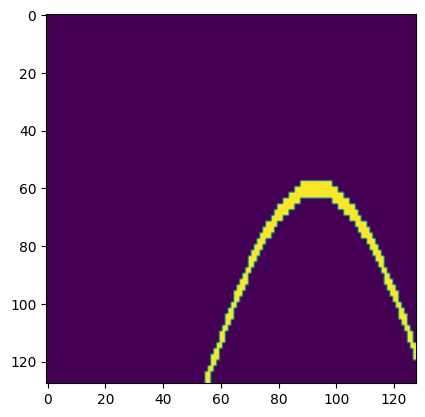

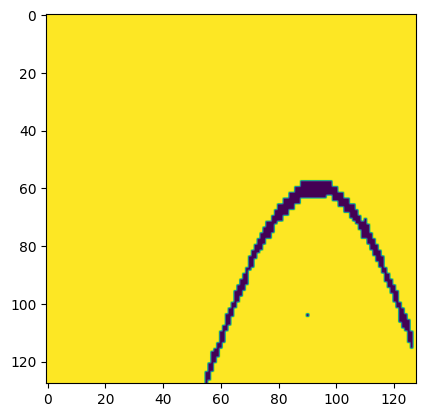

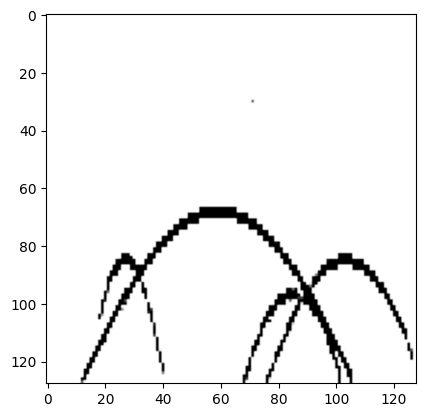

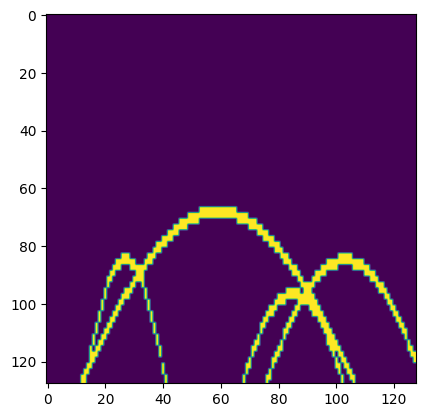

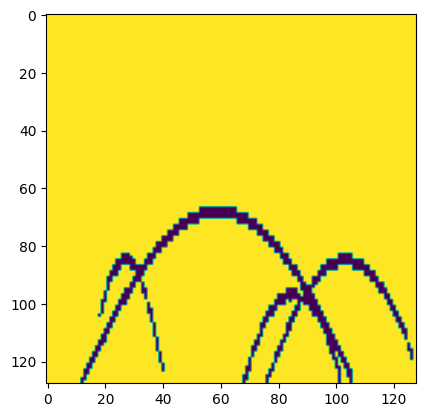

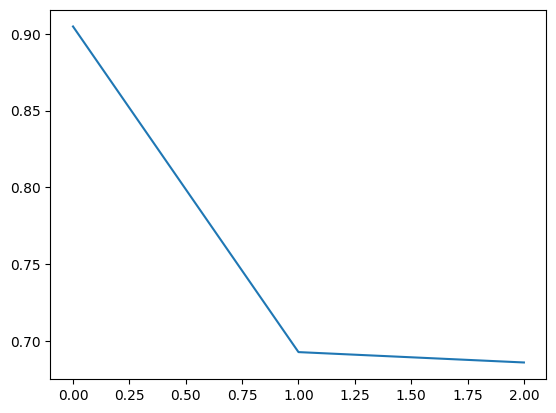

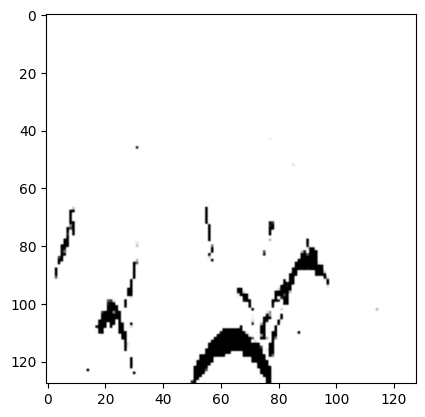

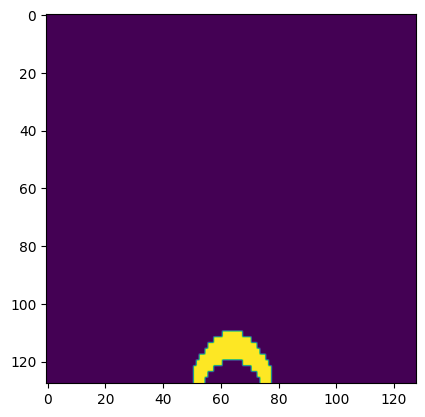

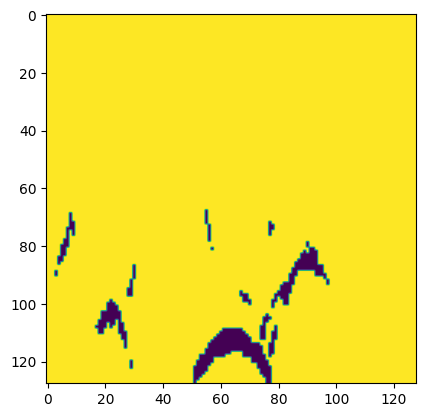

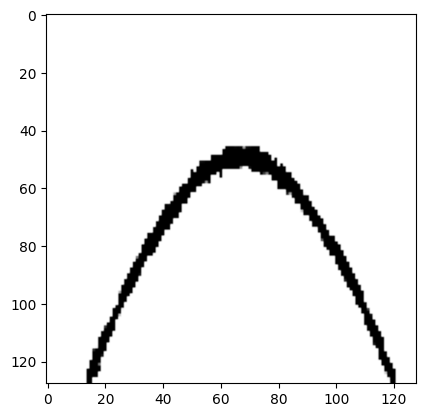

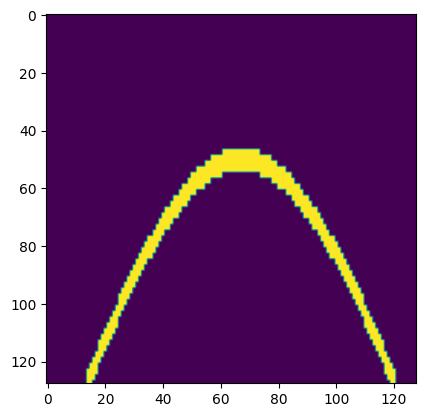

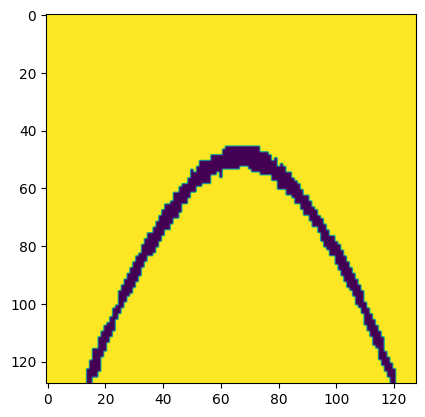

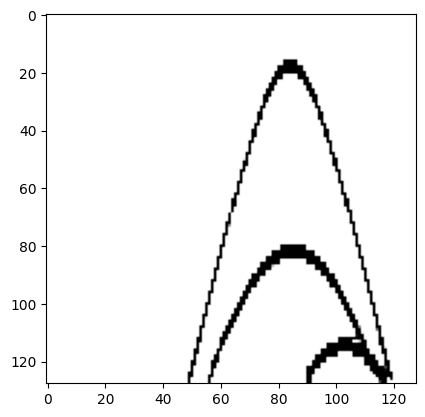

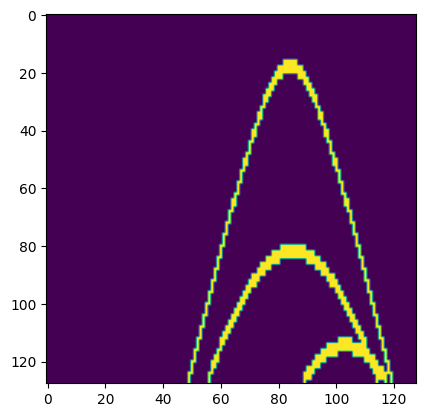

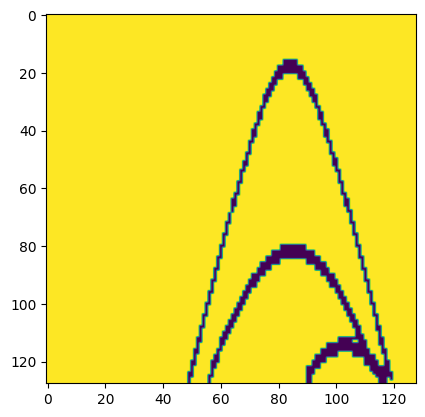

In [ ]:
lr_pow = config['learning_rate_pow']
epochs = config['max_epochs']
epoch_losses = []
mean_losses = []
output_num = 0
for epoch in range(epochs):
    losses = []
    
    optimizer =  torch.optim.Adam(helper_model.parameters(),
                              lr = 10**lr_pow)
    for num, trace in enumerate(training_generator):
        trace_ = trace[0].to(device)
        optimizer.zero_grad()
        reconstructed = helper_model(trace_)
        trace_y = trace[1].to(device)
        loss = dice_loss(reconstructed, trace_y) + loss_function(reconstructed, trace_y)
        losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        if num % 10 == 0:
            plt.imshow(trace_.cpu().detach()[0,0,:,:],cmap = 'Greys')
            plt.show()
            plt.imshow(trace_y.cpu().detach()[0,0,:,:])
            plt.show()
            plt.imshow(torch.argmax(helper_model(trace_)[0].cpu().detach(),dim = 0)[:,:])
            plt.show()
        del trace
        del trace_
        del trace_y
    mean_losses.append(np.mean(losses))
    plt.plot(mean_losses)
    plt.show()